In [246]:
import math
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.neighbors import (
    RadiusNeighborsClassifier,
    NeighborhoodComponentsAnalysis,
    KNeighborsClassifier,
)
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

data = {
    "model": [],
    "MAE": [],
    "MSE": [],
    "RMSE": [],
    "train_score": [],
    "test_score": [],
}
models = pd.DataFrame(columns=data)

pd.options.display.max_columns = None
titanic = pd.read_csv(
    r"/home/ahmed/Ai/Kaggle-Competitions-Notebooks/Titanic/DataStes/train.csv"
)
test = pd.read_csv(
    r"/home/ahmed/Ai/Kaggle-Competitions-Notebooks/Titanic/DataStes/test.csv"
)
ids = test["PassengerId"]

test

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...
413,1305,3,"Spector, Mr. Woolf",male,NaN,0,0,A.5. 3236,8.0500,NaN,S
414,1306,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9000,C105,C
415,1307,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,NaN,S
416,1308,3,"Ware, Mr. Frederick",male,NaN,0,0,359309,8.0500,NaN,S


    pclass : Ticket class	1 = 1st, 2 = 2nd, 3 = 3rd

    sibsp	# of siblings / spouses aboard the Titanic

    parch	# of parents / children aboard the Titanic

    ticket	Ticket number

    fare	Passenger fare

    embarked	Port of Embarkation	C = Cherbourg, Q = Queenstown, S = Southampton


# EDA


In [247]:
titanic.describe(include="all")

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
count,891.000000,891.000000,891.000000,891,891,714.000000,891.000000,891.000000,891,891.000000,204,889
unique,NaN,NaN,NaN,891,2,NaN,NaN,NaN,681,NaN,147,3
top,NaN,NaN,NaN,"Braund, Mr. Owen Harris",male,NaN,NaN,NaN,347082,NaN,B96 B98,S
freq,NaN,NaN,NaN,1,577,NaN,NaN,NaN,7,NaN,4,644
mean,446.000000,0.383838,2.308642,NaN,NaN,29.699118,0.523008,0.381594,NaN,32.204208,NaN,NaN
std,257.353842,0.486592,0.836071,NaN,NaN,14.526497,1.102743,0.806057,NaN,49.693429,NaN,NaN
min,1.000000,0.000000,1.000000,NaN,NaN,0.420000,0.000000,0.000000,NaN,0.000000,NaN,NaN
25%,223.500000,0.000000,2.000000,NaN,NaN,20.125000,0.000000,0.000000,NaN,7.910400,NaN,NaN
50%,446.000000,0.000000,3.000000,NaN,NaN,28.000000,0.000000,0.000000,NaN,14.454200,NaN,NaN
75%,668.500000,1.000000,3.000000,NaN,NaN,38.000000,1.000000,0.000000,NaN,31.000000,NaN,NaN


In [248]:
titanic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [249]:
titanic.isna().sum() * 100 / len(titanic)

PassengerId     0.000000
Survived        0.000000
Pclass          0.000000
Name            0.000000
Sex             0.000000
Age            19.865320
SibSp           0.000000
Parch           0.000000
Ticket          0.000000
Fare            0.000000
Cabin          77.104377
Embarked        0.224467
dtype: float64

<div class="alert alert-block alert-info">
    <span style='font-family:Georgia'>
        <b>Insight: Drop Cabin column, since it has  77 % missing data</b><br>
        <b>Insight: Drop name, PassengerId and Ticket columns, since this columns is not important</b><br>
    </span>    
</div>


31.871345029239766
68.12865497076024


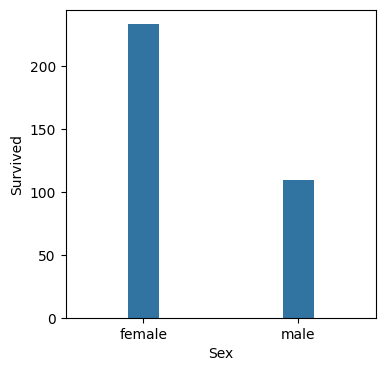

In [250]:
print(
    len(titanic[(titanic["Sex"] == "male") & (titanic["Survived"] == 1)])
    * 100
    / len(titanic[titanic["Survived"] == 1])
)
print(
    len(titanic[(titanic["Sex"] == "female") & (titanic["Survived"] == 1)])
    * 100
    / len(titanic[titanic["Survived"] == 1])
)

plt.figure(figsize=(4, 4))

data = titanic[titanic["Survived"] == 1]
sns.barplot(data=data, x="Sex", y="Survived", width=0.2, estimator="sum")
plt.show()

<div class="alert alert-block alert-info">
    <span style='font-family:Georgia'>
        <b>Insight: as a prediction, females have a much higher chance of survival than males</b><br>
    </span>    
</div>


39.76608187134503
25.43859649122807
34.7953216374269


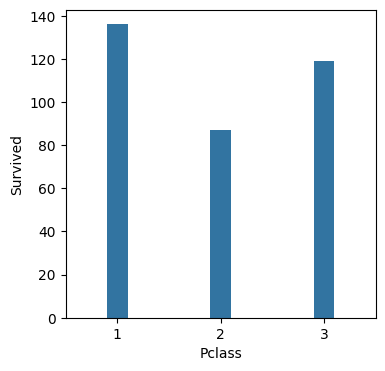

In [251]:
print(
    len(titanic[(titanic["Pclass"] == 1) & (titanic["Survived"] == 1)])
    * 100
    / len(titanic[titanic["Survived"] == 1])
)
print(
    len(titanic[(titanic["Pclass"] == 2) & (titanic["Survived"] == 1)])
    * 100
    / len(titanic[titanic["Survived"] == 1])
)

print(
    len(titanic[(titanic["Pclass"] == 3) & (titanic["Survived"] == 1)])
    * 100
    / len(titanic[titanic["Survived"] == 1])
)


plt.figure(figsize=(4, 4))
data = titanic[titanic["Survived"] == 1]
sns.barplot(data=data, x="Pclass", y="Survived", width=0.2, estimator="sum")
plt.show()

<div class="alert alert-block alert-info">
    <span style='font-family:Georgia'>
        <b>Insight: the class is not effected sinece people in 3rd class and Survived more the  in 2rd class</b><br>
    </span>    
</div>


0  : 61.40350877192982
1  : 32.748538011695906
2  : 3.801169590643275
3  : 1.1695906432748537
4  : 0.8771929824561403


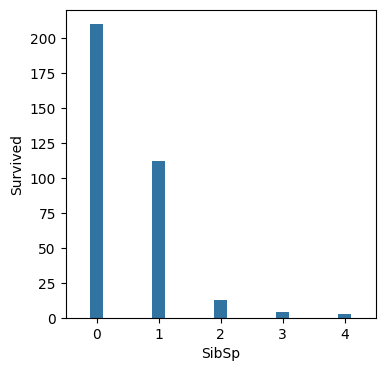

In [252]:
data = titanic[titanic["Survived"] == 1]

arr = data["SibSp"].unique()
arr = list(arr)
arr.sort()
for val in arr:
    print(val, " :", len(data[(data["SibSp"] == val)]) * 100 / len(data))

plt.figure(figsize=(4, 4))
sns.barplot(data=data, x="SibSp", y="Survived", width=0.2, estimator="sum")
plt.show()

<div class="alert alert-block alert-info">
    <span style='font-family:Georgia'>
        <b>Insight: as a prediction, when you have less number of siblings or spouses, you will have a much higher chance of survival</b><br>
    </span>    
</div>


<Axes: xlabel='Age', ylabel='Survived'>

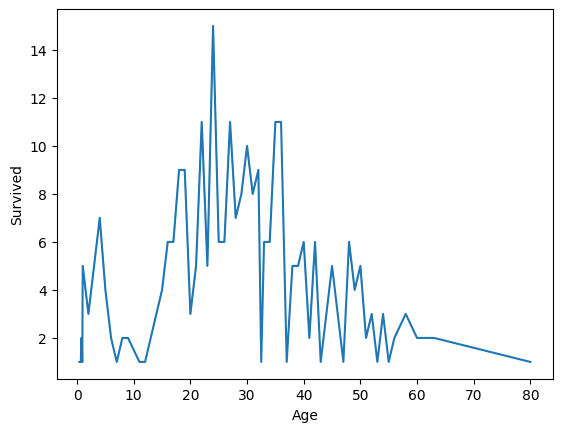

In [253]:
data = titanic[titanic["Survived"] == 1]

sns.lineplot(data=data, x="Age", y="Survived", estimator="sum")

# Cleaning


In [254]:
Drop_columns = ["Pclass", "Cabin", "Name", "PassengerId", "Ticket"]
titanic = titanic.drop(columns=Drop_columns, axis="columns")
titanic["Embarked"] = titanic["Embarked"].fillna(titanic["Embarked"].mode()[0])
titanic["Age"] = titanic["Age"].fillna(int(titanic["Age"].mean()))

In [255]:
titanic.isna().sum()

Survived    0
Sex         0
Age         0
SibSp       0
Parch       0
Fare        0
Embarked    0
dtype: int64

In [256]:
titanic

,Survived,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,male,22.0,1,0,7.2500,S
1,1,female,38.0,1,0,71.2833,C
2,1,female,26.0,0,0,7.9250,S
3,1,female,35.0,1,0,53.1000,S
4,0,male,35.0,0,0,8.0500,S
...,...,...,...,...,...,...,...
886,0,male,27.0,0,0,13.0000,S
887,1,female,19.0,0,0,30.0000,S
888,0,female,29.0,1,2,23.4500,S
889,1,male,26.0,0,0,30.0000,C


### Encoding and Grouping


In [257]:
bins = [-1, 0, 5, 12, 18, 24, 35, 60, np.inf]
labels = [
    "Unknown",
    "baby",
    "child",
    "teenager",
    "student",
    "young adult",
    "adult",
    "Senior",
]
titanic["AgeGroup"] = pd.cut(titanic["Age"], bins, labels=labels)
titanic = titanic.drop("Age", axis="columns")
titanic

,Survived,Sex,SibSp,Parch,Fare,Embarked,AgeGroup
0,0,male,1,0,7.2500,S,student
1,1,female,1,0,71.2833,C,adult
2,1,female,0,0,7.9250,S,young adult
3,1,female,1,0,53.1000,S,young adult
4,0,male,0,0,8.0500,S,young adult
...,...,...,...,...,...,...,...
886,0,male,0,0,13.0000,S,young adult
887,1,female,0,0,30.0000,S,student
888,0,female,1,2,23.4500,S,young adult
889,1,male,0,0,30.0000,C,young adult


In [258]:
titanic = pd.get_dummies(
    titanic, drop_first=True, columns=["Sex", "Embarked", "AgeGroup"]
)
for col in titanic.columns:
    if titanic[col].dtype == "bool":
        titanic[col] = titanic[col].astype("int32")
titanic

,Survived,SibSp,Parch,Fare,Sex_male,Embarked_Q,Embarked_S,AgeGroup_baby,AgeGroup_child,AgeGroup_teenager,AgeGroup_student,AgeGroup_young adult,AgeGroup_adult,AgeGroup_Senior
0,0,1,0,7.2500,1,0,1,0,0,0,1,0,0,0
1,1,1,0,71.2833,0,0,0,0,0,0,0,0,1,0
2,1,0,0,7.9250,0,0,1,0,0,0,0,1,0,0
3,1,1,0,53.1000,0,0,1,0,0,0,0,1,0,0
4,0,0,0,8.0500,1,0,1,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,0,0,0,13.0000,1,0,1,0,0,0,0,1,0,0
887,1,0,0,30.0000,0,0,1,0,0,0,1,0,0,0
888,0,1,2,23.4500,0,0,1,0,0,0,0,1,0,0
889,1,0,0,30.0000,1,0,0,0,0,0,0,1,0,0


In [259]:
def update(fare):
    if fare < 8:
        return 0
    if fare < 14.5:
        return 1
    if fare < 31:
        return 2
    return 3


titanic["Fare"] = titanic["Fare"].apply(update)
titanic

,Survived,SibSp,Parch,Fare,Sex_male,Embarked_Q,Embarked_S,AgeGroup_baby,AgeGroup_child,AgeGroup_teenager,AgeGroup_student,AgeGroup_young adult,AgeGroup_adult,AgeGroup_Senior
0,0,1,0,0,1,0,1,0,0,0,1,0,0,0
1,1,1,0,3,0,0,0,0,0,0,0,0,1,0
2,1,0,0,0,0,0,1,0,0,0,0,1,0,0
3,1,1,0,3,0,0,1,0,0,0,0,1,0,0
4,0,0,0,1,1,0,1,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,0,0,0,1,1,0,1,0,0,0,0,1,0,0
887,1,0,0,2,0,0,1,0,0,0,1,0,0,0
888,0,1,2,2,0,0,1,0,0,0,0,1,0,0
889,1,0,0,2,1,0,0,0,0,0,0,1,0,0


## same for testing data


In [260]:
Drop_columns = ["Pclass", "Cabin", "Name", "PassengerId", "Ticket"]
test = test.drop(columns=Drop_columns, axis="columns")

test["Embarked"] = test["Embarked"].fillna(test["Embarked"].mode()[0])
test["Age"] = test["Age"].fillna(int(test["Age"].mean()))
test["Fare"] = test["Fare"].fillna(test["Fare"].mean())
bins = [-1, 0, 5, 12, 18, 24, 35, 60, np.inf]
labels = [
    "Unknown",
    "baby",
    "child",
    "teenager",
    "student",
    "young adult",
    "adult",
    "Senior",
]
test["AgeGroup"] = pd.cut(test["Age"], bins, labels=labels)


test = pd.get_dummies(test, drop_first=True, columns=["Sex", "Embarked", "AgeGroup"])
for col in test.columns:
    if test[col].dtype == "bool":
        test[col] = test[col].astype("int32")


def update(fare):
    if fare < 8:
        return 0
    if fare < 14.5:
        return 1
    if fare < 31:
        return 2
    return 3


test["Fare"] = test["Fare"].apply(update)
test

test = test.drop(columns="Age", axis="columns")
test

,SibSp,Parch,Fare,Sex_male,Embarked_Q,Embarked_S,AgeGroup_baby,AgeGroup_child,AgeGroup_teenager,AgeGroup_student,AgeGroup_young adult,AgeGroup_adult,AgeGroup_Senior
0,0,0,0,1,1,0,0,0,0,0,1,0,0
1,1,0,0,0,0,1,0,0,0,0,0,1,0
2,0,0,1,1,1,0,0,0,0,0,0,0,1
3,0,0,1,1,0,1,0,0,0,0,1,0,0
4,1,1,1,0,0,1,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
413,0,0,1,1,0,1,0,0,0,0,1,0,0
414,0,0,3,0,0,0,0,0,0,0,0,1,0
415,0,0,0,1,0,1,0,0,0,0,0,1,0
416,0,0,1,1,0,1,0,0,0,0,1,0,0


# Spliting data


In [261]:
x_train, x_test, y_train, y_test = train_test_split(
    titanic.drop(columns="Survived", axis="columns"),
    titanic["Survived"],
    random_state=34,
    test_size=0.3,
)

print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(623, 13)
(623,)
(268, 13)
(268,)


# Models

- Logistic Regression
- k-Nearest Neighbors
- R-Nearest Neighbors
- Decision Tree Classifier
- Random Forest Classifier


## 1) LogisticRegression


In [262]:
log_reg = LogisticRegression(max_iter=1000, random_state=42)
log_reg.fit(X=x_train, y=y_train)

train_score = log_reg.score(x_train, y_train)
test_score = log_reg.score(x_test, y_test)

print("train score = ", train_score)
print("train score = ", test_score)

train score =  0.797752808988764
train score =  0.8208955223880597


In [263]:
log_reg_prediction = log_reg.predict(x_test)
MAE = mean_absolute_error(y_pred=log_reg_prediction, y_true=y_test)
MSE = mean_squared_error(y_pred=log_reg_prediction, y_true=y_test)
RMSE = np.sqrt(MSE)
MAE, MSE, RMSE

(0.1791044776119403, 0.1791044776119403, 0.42320736951515897)

In [264]:
data = {
    "model": "LogisticRegression",
    "MAE": MAE,
    "MSE": MSE,
    "RMSE": RMSE,
    "train_score": train_score,
    "test_score": test_score,
}

models.loc[len(models)] = data
models

,model,MAE,MSE,RMSE,train_score,test_score
0,LogisticRegression,0.179104,0.179104,0.423207,0.797753,0.820896


## 2) k-Nearest Neighbors


In [265]:
num_neighbors = int(np.sqrt(len(x_train)))

neighbors = [num_neighbors]
for i in range(9):
    neighbors.append(num_neighbors + i + 1)
for i in range(9):
    neighbors.append(num_neighbors - (i + 1))

KNC_models = []
Cross_valdation = []

for k in neighbors:
    KNC = KNeighborsClassifier(n_neighbors=k, algorithm="ball_tree")
    KNC.fit(X=x_train, y=y_train)
    valdation = cross_val_score(KNC, X=x_train, y=y_train, cv=4)
    KNC_models.append(KNC)
    Cross_valdation.append([k, np.mean(valdation), np.std(valdation)])

train_score = [KNC_.score(x_train, y_train) for KNC_ in KNC_models]
test_score = [KNC_.score(x_test, y_test) for KNC_ in KNC_models]


Cross_valdation_results = pd.DataFrame(
    Cross_valdation, columns=["K-neighbors", "mean_acc", "std"]
)

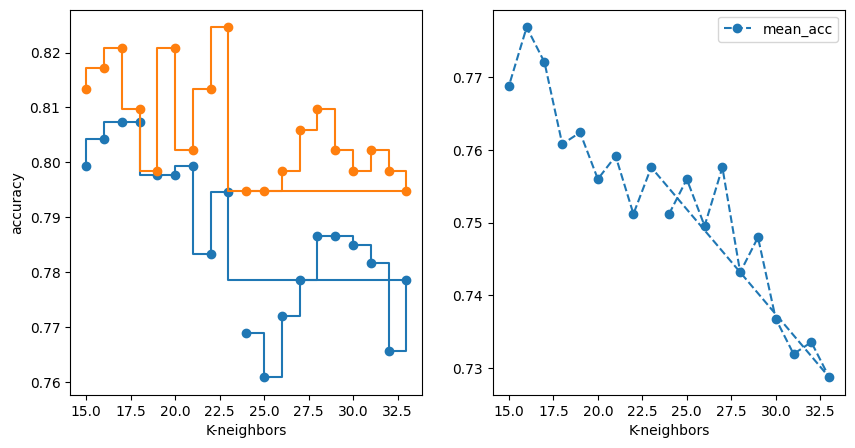

In [266]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
ax[0].set_xlabel("K-neighbors")
ax[0].set_ylabel("accuracy")
ax[0].plot(neighbors, train_score, marker="o", label="train", drawstyle="steps-post")
ax[0].plot(neighbors, test_score, marker="o", label="test", drawstyle="steps-post")

Cross_valdation_results.plot(
    x="K-neighbors", y="mean_acc", linestyle="--", marker="o", ax=ax[1]
)

plt.legend()
plt.show()

### By the cross val score, when the data set changed the model becomes unstabel, more formally this model is not good


### BEST K is 23, with about .73 score for traing and 0.75 score for testing


In [267]:
KNC = KNeighborsClassifier(n_neighbors=23, algorithm="ball_tree")
KNC.fit(X=x_train, y=y_train)
train_score = KNC.score(x_train, y_train)
test_score = KNC.score(x_test, y_test)

print("train score = ", train_score)
print("train score = ", test_score)

train score =  0.7945425361155698
train score =  0.8246268656716418


In [268]:
KNC_prediction = KNC.predict(x_test)
MAE = mean_absolute_error(y_pred=KNC_prediction, y_true=y_test)
MSE = mean_squared_error(y_pred=KNC_prediction, y_true=y_test)
RMSE = np.sqrt(MSE)
MAE, MSE, RMSE

(0.17537313432835822, 0.17537313432835822, 0.41877575661487165)

In [269]:
data = {
    "model": "KNeighborsClassifier",
    "MAE": MAE,
    "MSE": MSE,
    "RMSE": RMSE,
    "train_score": train_score,
    "test_score": test_score,
}

models.loc[len(models)] = data
models

,model,MAE,MSE,RMSE,train_score,test_score
0,LogisticRegression,0.179104,0.179104,0.423207,0.797753,0.820896
1,KNeighborsClassifier,0.175373,0.175373,0.418776,0.794543,0.824627


## 3) R-Nearest Neighbors


In [270]:
R = 40

Raduisies = [R]
for i in range(20):
    Raduisies.append(R + i + 0.5)

for i in range(20):
    Raduisies.append(R - (i + 0.5))

RNC_models = []
Cross_valdation = []

for r in Raduisies:
    RNC = RadiusNeighborsClassifier(radius=r, algorithm="ball_tree")
    RNC.fit(X=x_train, y=y_train)
    valdation = cross_val_score(RNC, X=x_train, y=y_train, cv=4)
    RNC_models.append(RNC)
    Cross_valdation.append([r, np.mean(valdation), np.std(valdation)])

train_score = [RNC_.score(x_train, y_train) for RNC_ in RNC_models]
test_score = [RNC_.score(x_test, y_test) for RNC_ in RNC_models]


Cross_valdation_results = pd.DataFrame(
    Cross_valdation, columns=["R-neighbors", "mean_acc", "std"]
)

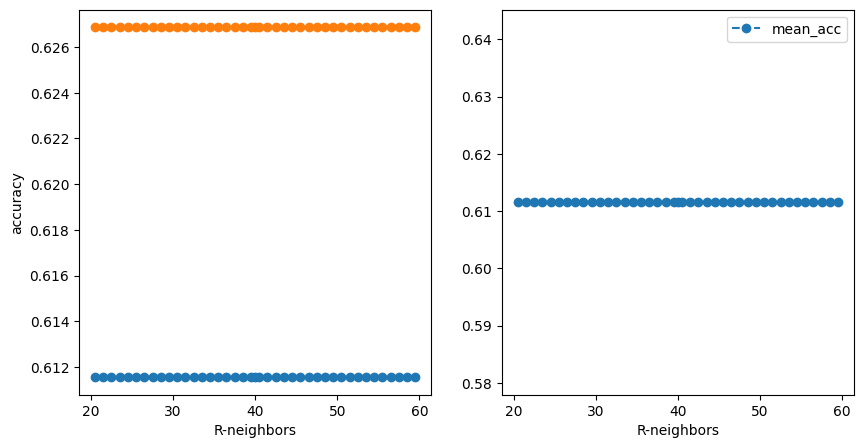

In [271]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
ax[0].set_xlabel("R-neighbors")
ax[0].set_ylabel("accuracy")
ax[0].plot(Raduisies, train_score, marker="o", label="train", drawstyle="steps-post")
ax[0].plot(Raduisies, test_score, marker="o", label="test", drawstyle="steps-post")

Cross_valdation_results.plot(
    x="R-neighbors", y="mean_acc", linestyle="--", marker="o", ax=ax[1]
)

plt.legend()
plt.show()

### I think it is a bad decision to choose RadiusNeighborsClassifier model 🤣🤣🤣


### How ever, i will choose 40.5 as a raduis


In [272]:
RNC = RadiusNeighborsClassifier(radius=40.5, algorithm="ball_tree")
RNC.fit(X=x_train, y=y_train)
train_score = RNC.score(x_train, y_train)
test_score = RNC.score(x_test, y_test)

print("train score = ", train_score)
print("train score = ", test_score)

train score =  0.6115569823434992
train score =  0.6268656716417911


In [273]:
RNC_prediction = RNC.predict(x_test)
MAE = mean_absolute_error(y_pred=RNC_prediction, y_true=y_test)
MSE = mean_squared_error(y_pred=RNC_prediction, y_true=y_test)
RMSE = np.sqrt(MSE)
MAE, MSE, RMSE

(0.373134328358209, 0.373134328358209, 0.6108472217815262)

In [274]:
data = {
    "model": "RadiusNeighborsClassifier",
    "MAE": MAE,
    "MSE": MSE,
    "RMSE": RMSE,
    "train_score": train_score,
    "test_score": test_score,
}

models.loc[len(models)] = data
models

,model,MAE,MSE,RMSE,train_score,test_score
0,LogisticRegression,0.179104,0.179104,0.423207,0.797753,0.820896
1,KNeighborsClassifier,0.175373,0.175373,0.418776,0.794543,0.824627
2,RadiusNeighborsClassifier,0.373134,0.373134,0.610847,0.611557,0.626866


## 4) Decision Tree Classifier


In [275]:
DTC = DecisionTreeClassifier(random_state=42)
DTC.fit(x_train, y_train)

DecisionTreeClassifier(random_state=42)

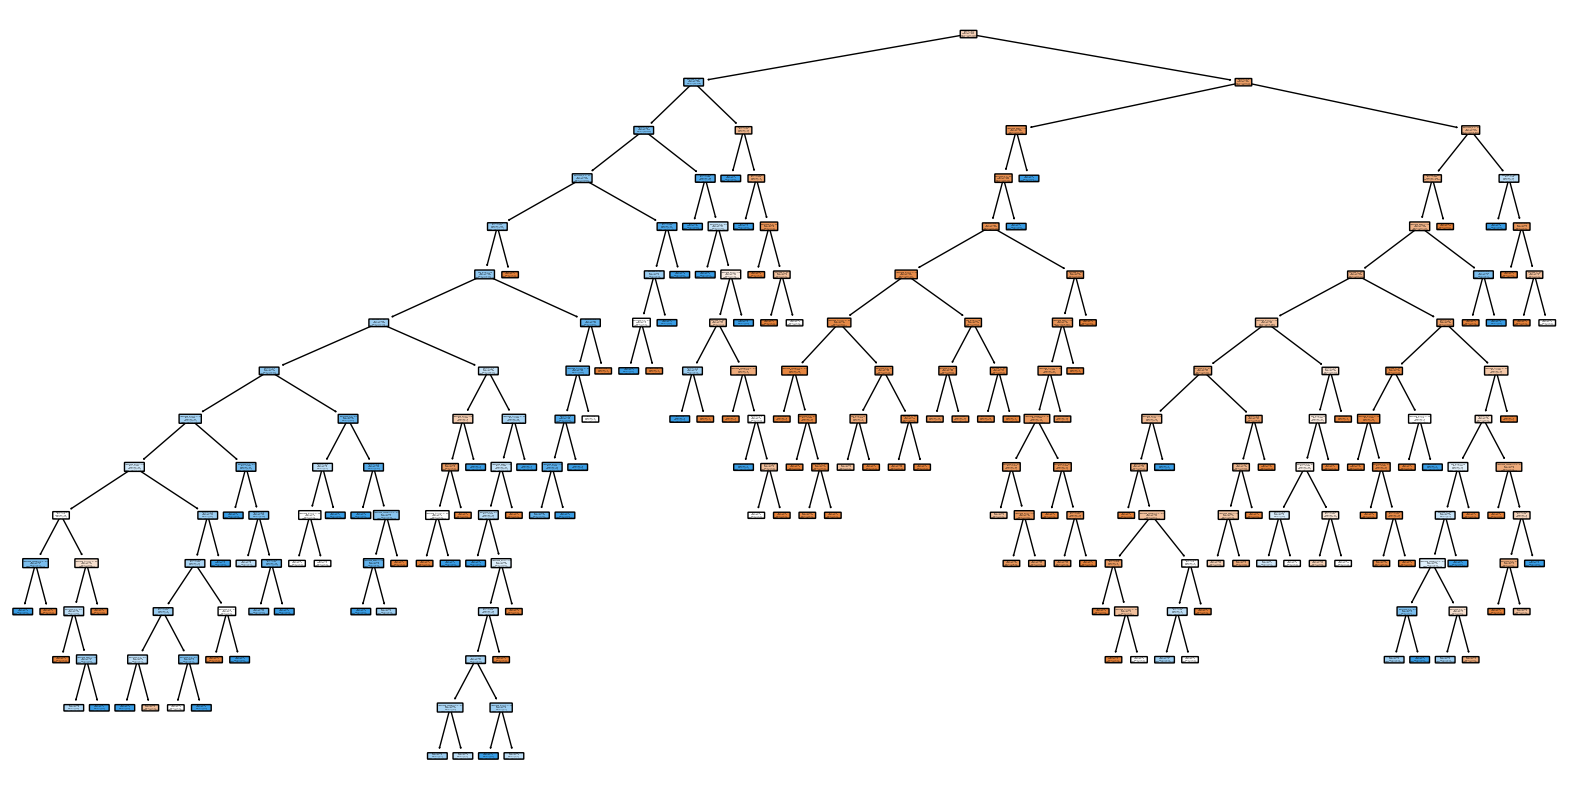

In [276]:
plt.figure(figsize=(20, 10))
plot_tree(
    DTC,
    class_names=["will Survive", "will not Survive"],
    filled=True,
    rounded=True,
    feature_names=titanic.columns,
)
plt.show()

### I think this tree over fit the model


In [277]:
print(DTC.score(x_train, y_train))
print(DTC.score(x_test, y_test))

0.8747993579454254
0.7947761194029851


### as I expected, there is an overfit probelm, let's fix it by pruning the tree


In [278]:
path = DTC.cost_complexity_pruning_path(x_train, y_train)
alphas = path.ccp_alphas
alphas = alphas[:-1]
DTC_models = []

Cross_valdation = []

for alpha in alphas:
    DTC = DecisionTreeClassifier(random_state=42, ccp_alpha=alpha)
    DTC.fit(x_train, y_train)
    score = cross_val_score(DTC, x_train, y_train, cv=5)
    Cross_valdation.append([alpha, np.mean(score), np.std(score)])
    DTC_models.append(DTC)


train_score = [DTC_.score(x_train, y_train) for DTC_ in DTC_models]
test_score = [DTC_.score(x_test, y_test) for DTC_ in DTC_models]

alpha_results = pd.DataFrame(Cross_valdation, columns=["alpha", "mean_acc", "std"])

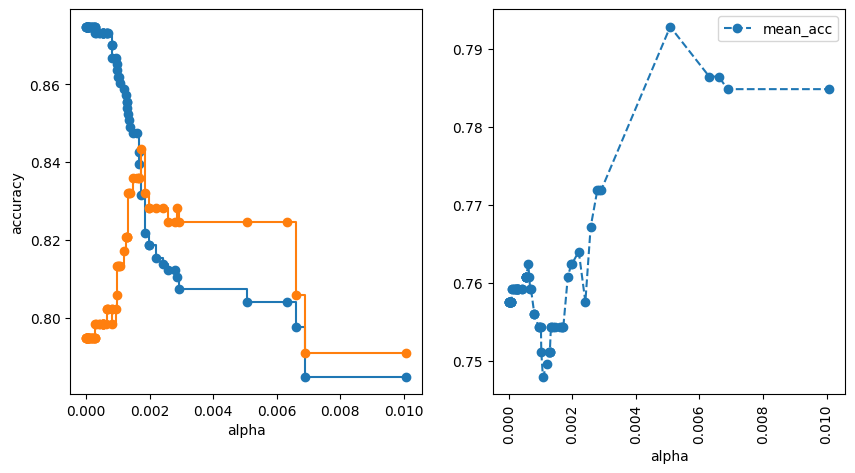

In [279]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
ax[0].set_xlabel("alpha")
ax[0].set_ylabel("accuracy")

ax[0].plot(alphas, train_score, marker="o", label="train", drawstyle="steps-post")
plt.xticks(rotation=90)

ax[0].plot(alphas, test_score, marker="o", label="test", drawstyle="steps-post")
plt.xticks(rotation=90)

alpha_results.plot(x="alpha", y="mean_acc", linestyle="--", marker="o", ax=ax[1])
plt.xticks(rotation=90)
plt.legend()
plt.show()

In [280]:
alpha = alpha_results[
    (alpha_results["alpha"] <= 0.002) & (alpha_results["alpha"] > 0.0014)
]["alpha"]

alpha

58    0.001466
59    0.001605
60    0.001665
61    0.001678
62    0.001713
63    0.001855
64    0.001966
65    0.001981
Name: alpha, dtype: float64

In [281]:
DTC_pruned = DecisionTreeClassifier(ccp_alpha=0.001713, random_state=42)
DTC_pruned.fit(x_train, y_train)
train_score = DTC_pruned.score(x_train, y_train)
test_score = DTC_pruned.score(x_test, y_test)

print("train score = ", train_score)
print("train score = ", test_score)

train score =  0.8314606741573034
train score =  0.8432835820895522


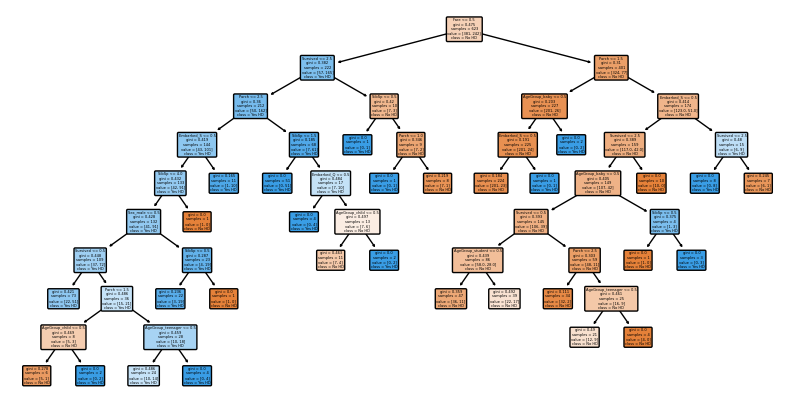

In [282]:
plt.figure(figsize=(10, 5))
plot_tree(
    DTC_pruned,
    class_names=["No HD", "Yes HD"],
    filled=True,
    rounded=True,
    feature_names=titanic.columns,
)
plt.show()

### Great work


In [283]:
DTC_pruned_prediction = DTC_pruned.predict(x_test)
MAE = mean_absolute_error(y_pred=DTC_pruned_prediction, y_true=y_test)
MSE = mean_squared_error(y_pred=DTC_pruned_prediction, y_true=y_test)
RMSE = np.sqrt(MSE)
MAE, MSE, RMSE

(0.15671641791044777, 0.15671641791044777, 0.39587424507089086)

In [284]:
data = {
    "model": "DecisionTreeClassifier",
    "MAE": MAE,
    "MSE": MSE,
    "RMSE": RMSE,
    "train_score": train_score,
    "test_score": test_score,
}

models.loc[len(models)] = data
models

,model,MAE,MSE,RMSE,train_score,test_score
0,LogisticRegression,0.179104,0.179104,0.423207,0.797753,0.820896
1,KNeighborsClassifier,0.175373,0.175373,0.418776,0.794543,0.824627
2,RadiusNeighborsClassifier,0.373134,0.373134,0.610847,0.611557,0.626866
3,DecisionTreeClassifier,0.156716,0.156716,0.395874,0.831461,0.843284


# 5) Random Forest


In [285]:
RF = RandomForestClassifier(n_estimators=20, random_state=42, ccp_alpha=0.002408)
RF.fit(X=x_train, y=y_train)
RF.score(X=x_train, y=y_train), RF.score(X=x_test, y=y_test)

(0.8362760834670947, 0.8208955223880597)

In [286]:
path = DTC.cost_complexity_pruning_path(x_train, y_train)
alphas = path.ccp_alphas
alphas = alphas[:-1]

RF_models = []

Cross_valdation = []

for alpha in alphas:
    RF = RandomForestClassifier(n_estimators=20, random_state=42, ccp_alpha=alpha)
    RF.fit(x_train, y_train)
    score = cross_val_score(RF, x_train, y_train, cv=5)
    Cross_valdation.append([alpha, np.mean(score), np.std(score)])
    RF_models.append(RF)


train_score = [RF_.score(x_train, y_train) for RF_ in RF_models]
test_score = [RF_.score(x_test, y_test) for RF_ in RF_models]

alpha_results = pd.DataFrame(Cross_valdation, columns=["alpha", "mean_acc", "std"])

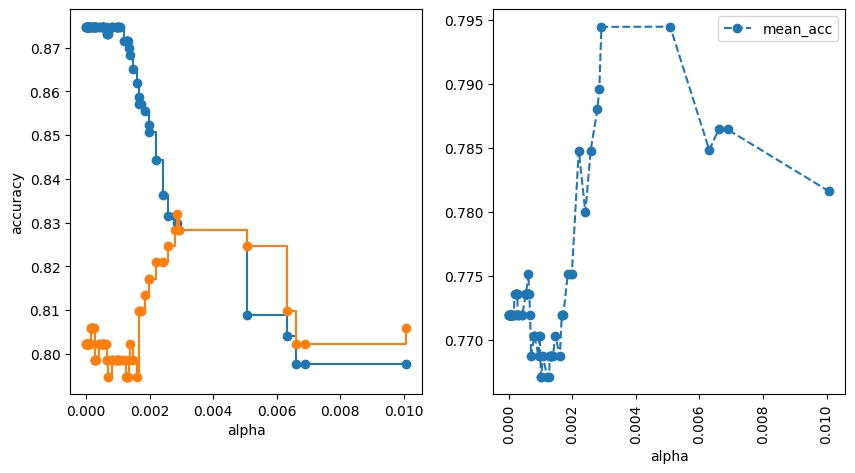

In [287]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
ax[0].set_xlabel("alpha")
ax[0].set_ylabel("accuracy")

ax[0].plot(alphas, train_score, marker="o", label="train", drawstyle="steps-post")
plt.xticks(rotation=90)

ax[0].plot(alphas, test_score, marker="o", label="test", drawstyle="steps-post")
plt.xticks(rotation=90)

alpha_results.plot(x="alpha", y="mean_acc", linestyle="--", marker="o", ax=ax[1])
plt.xticks(rotation=90)
plt.legend()
plt.show()

In [288]:
alpha = alpha_results[
    (alpha_results["alpha"] <= 0.0027) & (alpha_results["alpha"] >= 0.002)
]["alpha"]

alpha

66    0.002200
67    0.002408
68    0.002573
Name: alpha, dtype: float64

In [289]:
RF = RandomForestClassifier(n_estimators=20, random_state=42, ccp_alpha=00.002573)
RF.fit(X=x_train, y=y_train)
train_score = RF.score(x_train, y_train)
test_score = RF.score(x_test, y_test)

print("train score = ", train_score)
print("test score = ", test_score)

train score =  0.8314606741573034
test score =  0.8246268656716418


In [290]:
RF_prediction = RF.predict(x_test)
MAE = mean_absolute_error(y_pred=RF_prediction, y_true=y_test)
MSE = mean_squared_error(y_pred=RF_prediction, y_true=y_test)
RMSE = np.sqrt(MSE)
MAE, MSE, RMSE

(0.17537313432835822, 0.17537313432835822, 0.41877575661487165)

In [291]:
data = {
    "model": "RandomForestClassifier",
    "MAE": MAE,
    "MSE": MSE,
    "RMSE": RMSE,
    "train_score": train_score,
    "test_score": test_score,
}

models.loc[len(models)] = data
models

,model,MAE,MSE,RMSE,train_score,test_score
0,LogisticRegression,0.179104,0.179104,0.423207,0.797753,0.820896
1,KNeighborsClassifier,0.175373,0.175373,0.418776,0.794543,0.824627
2,RadiusNeighborsClassifier,0.373134,0.373134,0.610847,0.611557,0.626866
3,DecisionTreeClassifier,0.156716,0.156716,0.395874,0.831461,0.843284
4,RandomForestClassifier,0.175373,0.175373,0.418776,0.831461,0.824627


# Votting


In [292]:
models_ = [
    ("log_reg", log_reg, log_reg.score(x_train, y_train)),
    ("KNC", KNC, KNC.score(x_train, y_train)),
    ("RNC", RNC, RNC.score(x_train, y_train)),
    ("DTC_purned", DTC_pruned, DTC_pruned.score(x_train, y_train)),
    ("RF", RF, RF.score(x_train, y_train)),
]
vec = []


mx_test_score = 0

combinamtion = ()

Weight = []


def sub_mask(i):
    global mx_test_score, vec, combinamtion, Weight
    if i == len(models_):
        if len(vec) > 0:

            weights = []
            taken_models = []

            for i, j, k in vec:
                weights.append(k)
                taken_models.append((i, j))

            vot = VotingClassifier(
                estimators=taken_models, voting="soft", weights=weights
            )
            vot.fit(x_train, y_train)
            score = vot.score(x_test, y_test)
            if score > mx_test_score:
                mx_test_score = score
                combinamtion = taken_models.copy()
                Weight = weights.copy()

        return
    vec.append(models_[i])
    sub_mask(i + 1)
    vec.pop()
    sub_mask(i + 1)
    return


sub_mask(0)


vot = VotingClassifier(estimators=combinamtion, voting="soft", weights=Weight)
vot

VotingClassifier(estimators=[('log_reg',
                              LogisticRegression(max_iter=1000,
                                                 random_state=42)),
                             ('KNC',
                              KNeighborsClassifier(algorithm='ball_tree',
                                                   n_neighbors=23)),
                             ('RNC',
                              RadiusNeighborsClassifier(algorithm='ball_tree',
                                                        radius=40.5)),
                             ('DTC_purned',
                              DecisionTreeClassifier(ccp_alpha=0.001713,
                                                     random_state=42)),
                             ('RF',
                              RandomForestClassifier(ccp_alpha=0.002573,
                                                     n_estimators=20,
                                                     random_state=42))],
                 voting='soft',
                 weights=[0.797752808988764, 0.7945425361155698,
                          0.6115569823434992, 0.8314606741573034,
                          0.8314606741573034])

In [293]:
vot.fit(x_train, y_train)
train_score = vot.score(x_train, y_train)
test_score = vot.score(x_test, y_test)

print("train score = ", train_score)
print("test score = ", test_score)

train score =  0.8314606741573034
test score =  0.8544776119402985


In [294]:
vot_prediction = vot.predict(x_test)
MAE = mean_absolute_error(y_pred=RF_prediction, y_true=y_test)
MSE = mean_squared_error(y_pred=RF_prediction, y_true=y_test)
RMSE = np.sqrt(MSE)
MAE, MSE, RMSE

(0.17537313432835822, 0.17537313432835822, 0.41877575661487165)

In [295]:
data = {
    "model": "VotingClassifier",
    "MAE": MAE,
    "MSE": MSE,
    "RMSE": RMSE,
    "train_score": train_score,
    "test_score": test_score,
}

models.loc[len(models)] = data
models

,model,MAE,MSE,RMSE,train_score,test_score
0,LogisticRegression,0.179104,0.179104,0.423207,0.797753,0.820896
1,KNeighborsClassifier,0.175373,0.175373,0.418776,0.794543,0.824627
2,RadiusNeighborsClassifier,0.373134,0.373134,0.610847,0.611557,0.626866
3,DecisionTreeClassifier,0.156716,0.156716,0.395874,0.831461,0.843284
4,RandomForestClassifier,0.175373,0.175373,0.418776,0.831461,0.824627
5,VotingClassifier,0.175373,0.175373,0.418776,0.831461,0.854478


In [296]:
models.sort_values(by=["test_score"], ascending=[False])

,model,MAE,MSE,RMSE,train_score,test_score
5,VotingClassifier,0.175373,0.175373,0.418776,0.831461,0.854478
3,DecisionTreeClassifier,0.156716,0.156716,0.395874,0.831461,0.843284
1,KNeighborsClassifier,0.175373,0.175373,0.418776,0.794543,0.824627
4,RandomForestClassifier,0.175373,0.175373,0.418776,0.831461,0.824627
0,LogisticRegression,0.179104,0.179104,0.423207,0.797753,0.820896
2,RadiusNeighborsClassifier,0.373134,0.373134,0.610847,0.611557,0.626866


In [297]:
predictions = vot.predict(test)

submmition = pd.DataFrame({"PassengerId": ids, "Survived": predictions})
submmition.to_csv(
    "/home/ahmed/Ai/Kaggle-Competitions-Notebooks/Titanic/DataStes/submission.csv",
    index=False,
)

# The END
